In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geocoder
from time import sleep

In [2]:
from datetime import datetime

In [3]:
from scipy.optimize import fmin, fmin_bfgs

In [4]:
import seaborn as sns
sns.set(style="ticks", palette="Set2")

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
pwd

'/Users/mmngreco/Documents/repos/unizar/SIAD/Trabajo Grupo'

In [6]:
%matplotlib inline

# PROBLEMA 

## $\min_{x_0, y_0}{\sum{c_i · w_i · d_i}}$

## $d_i = \sqrt{(x_i - x_0)^2 + (y_i - x_0)^2}$

__DONDE:__

- $c_i$: Coste ¿unitario?.
- $w_i$: Unidades demandadas de bienes (media de los últimos 3 años)
- $d_i$: Distancia al almacén.
- $x_i$: Coordenada eje x (Longitud)
- $y_i$: Coordenada eje y (Latitud)

__Variables de decisión:__ $x_0, y_0$ 

In [7]:
def func_obj(xy0):
    'Función Obejtivo, xy0: Tupla, pares de coordenadas'
    return sum(wi * ci * di(xy0))
    

# SIMULACIÓN

## DEMANDA (CLIENTES)

### SERIE TEMPORAL TIPO:

### $y_t = \delta_0 + \delta_1 · t + u_t$

### Donde:
- $y_t$ : Ventas para cada período t.
- $\delta_0$ : Ventas indendientes o autónomas. (Stock de Seguridad pe.)
- $\delta_1$ : Pendiente la recta.
- $u_t$ : Ruido ~ N(0, 5)

En este caso para darle más realismo, $\delta_0 = \delta_a + \delta_b · sin(x)$, de esta forma introducimos un posible componente estacional, que depende cuán grande sea $\delta_b$.

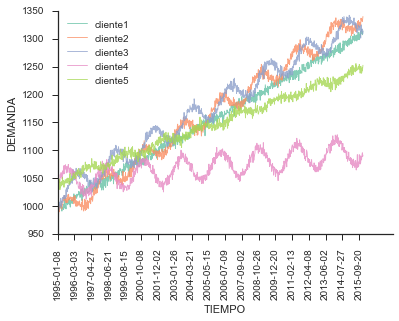

In [8]:
clientes = dict()
days_by_year = 365
nperiodos = 3 * days_by_year
tiempo = np.linspace(0 , 50, nperiodos)

for c in range(5):

    pendiente = np.random.uniform(0.5, 10)
    ruido = np.random.normal(0, 5, nperiodos)
    freq = np.random.normal(10, 10)
    demanda_a = np.random.normal(1000, 30)
    band = np.random.uniform() < 0.4
    demanda = demanda_a + (np.cos(tiempo)*band + np.sin(tiempo)*(1-band)) * freq + pendiente * tiempo + ruido
    cname = 'cliente%s' % (c+1)
    clientes[cname] = demanda

    plt.plot(demanda, alpha=0.8, label=cname, linewidth=0.91)

sns.despine()
plt.legend(loc=2)
tlabel = pd.date_range(end='2015-12-31', periods=nperiodos, freq='W')
plt.xlabel('TIEMPO')
plt.xticks(range(0, len(tiempo), 60), [t.date() for t in tlabel[0::60]], rotation=90)
plt.ylabel('DEMANDA')

In [9]:
ventas = pd.DataFrame.from_dict(clientes)

In [10]:
ventas.index = tlabel

In [11]:
ventas.head()

,cliente1,cliente2,cliente3,cliente4,cliente5
1995-01-08,1001.882532,988.124485,1005.830197,1045.424041,1042.500242
1995-01-15,993.910489,984.509996,1003.504886,1043.331527,1036.875651
1995-01-22,990.454211,997.091944,1007.819585,1051.512087,1042.498596
1995-01-29,1002.847670,981.018146,1002.316454,1045.604540,1038.132357
1995-02-05,994.668910,1002.043041,993.542939,1042.633348,1045.818970


In [12]:
path = 'Documents/repos/unizar/SIAD/Trabajo Grupo/'
data_clientes = pd.read_csv('clientes_xys.csv', index_col=0)

In [13]:
data_clientes

,prov,lat,lng
cliente1,zaragoza,41.648823,-0.889085
cliente2,oviedo,43.361915,-5.849389
cliente3,huesca,42.131845,-0.407806
cliente4,madrid,40.416775,-3.703790
cliente5,bilbao,43.263013,-2.934985


In [14]:
yi = data_clientes.lat.values
xi = data_clientes.lng.values

In [15]:
list(xi)

[-0.88908530000000008,
 -5.8493887000000004,
 -0.4078058,
 -3.7037902000000003,
 -2.9349852000000003]

## COSTES

$c_i$: Es el coste por unidad de producto vendida.

Suponemos que esta empresa ya maximiza beneficios y los precios son exógenos. Por tanto la oferta igual a la demanda, siendo ésta última estimada como la media de los últimos 3 años.

$w_i$ = $E(w_i|T)$

In [16]:
wi = ventas.mean()
ci = np.random.uniform(1, 100) + 1
di = lambda xy0: np.sqrt((xi-xy0[0]) ** 2 + (yi-xy0[1]) ** 2)

In [17]:
wi

cliente1    1152.360416
cliente2    1164.537127
cliente3    1176.534408
cliente4    1070.856337
cliente5    1144.718100
dtype: float64

# OPTIMIZACIÓN

In [18]:
res = fmin(func_obj, [0,0])

Optimization terminated successfully.
         Current function value: 964031.446709
         Iterations: 101
         Function evaluations: 195


In [19]:
res

array([ -2.41754415,  42.25590116])

# RESULTADO

Con los datos simulados, la solución óptima para el problema planteado es [ 42.23885306,  -2.5716388 ], y la función toma el valor 934296.653775.

In [20]:
file_name = 'xys_backup.csv'
file_name_new = 'pais_ca_prov_rejilla.csv'

In [21]:
muestra_xys = pd.read_csv(file_name_new)
muestra_xys.drop_duplicates(inplace=True)

In [22]:
muestra_xys.head()

,pais,ca,prov,lat,lng
0,PT,Setúbal,Grândola,38.180107,-8.71207
1,PT,Setúbal,Grândola,38.180107,-8.41926
2,PT,Faro,Silves,37.277379,-8.41926
3,PT,Bragança,Mogadouro,41.249382,-6.66240
4,PT,Bragança,Mogadouro,41.429927,-6.66240


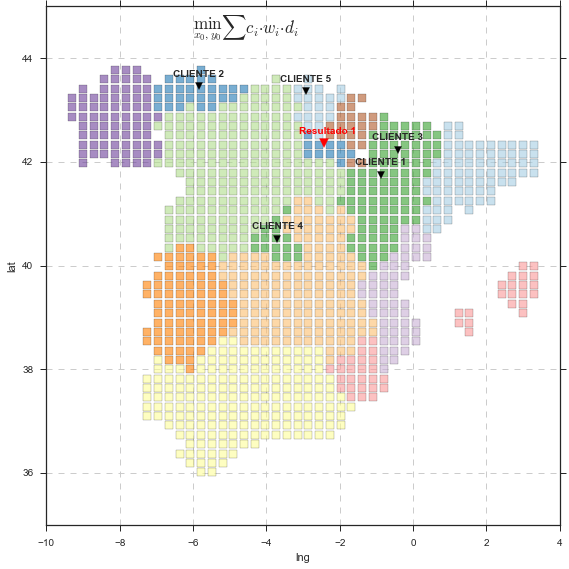

In [23]:
plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1)

color = sns.color_palette("Paired", 17)

n_color = list(map(int,'9  7 15 14 12 16 10  1  6  8 11 13  0  2  3  4  5'.split()))

# TERRITORIO
for i, region in enumerate(muestra_xys[muestra_xys.pais == 'ES'].ca.unique()):
    i = n_color[i]
    muestra_xys[muestra_xys.ca == region].plot(kind='scatter', 
                                               x='lng', 
                                               y='lat', 
                                               alpha=0.6, 
                                               ax=ax, 
                                               color=color[i], 
                                               marker='s',
                                               linewidths=.3,
                                               s=80)
# CLIENTES
for i, (y, x) in enumerate(zip(data_clientes.lat.values, data_clientes.lng.values)):

    plt.scatter(x, y*1.0025, color='black', marker='v', s=50)
    plt.text(x - 0.7,
             y + 0.3,
             'CLIENTE %s' % (i+1), weight='bold')

# RESULTADO
plt.scatter(res[0], res[1]*1.0025, color='red', marker='v', s=80)
plt.text(res[0] - 0.7, 
         res[1] + 0.3, 
         'Resultado 1',
         weight='bold',
         color='red')


plt.text(-6, 44.5, '$\min_{x_0,y_0}{\sum{c_i·w_i·d_i}}$', weight='bold', fontsize=17)

plt.xlim(-10,4)
ax.grid(True, linestyle='--')

plt.tight_layout()


> __NOTA:__ 
En los mapas físicos, las coordenadas están expresadas en grados, por ejemplo Puerto Rico sería: 18°14’70” N  66°29’68” W
Para convertir:
- $(18°14'70" N) = (18 + (14 / 60) + (70 / 3600)) = 18.252$
- $(66°29'68" W) = -(66 + (29 / 60) + (68 / 3600)) = -66.8627$

> La longitud se multiplica por __negativo__, porque está a la __izquierda (oeste)__ del punto 0,0.

# RESTRICCIÓN ADICIONAL

Al problema anterior, le agregamos una restricción adicional de tipo geográfica. Cada comunidad autónoma pasará a cobrar un impuesto por unidad vendida, el tipo impositivo dependerá de la comunidad autónoma, de forma que es probable que la elección óptima cambie.

Es decir:

# PROBLEMA INICIAL + RESTRICCIÓN

## $\min_{x_0, y_0}{\sum{c_i(1+t_i) · w_i · d_i}}$

__DONDE:__

- $c_i$: Coste unitario.
- $w_i$: Unidades demandadas de bienes (media de los últimos 3 años).
- $d_i$: Distancia al almacén.
- $x_i$: Coordenada eje x (Longitud).
- $y_i$: Coordenada eje y (Latitud).
- __$t_i$: Impuesto por unidad vendida.__

__Variables de decisión (Coordenadas):__ $x_0, y_0$ 


In [24]:
muestra_xys.head()

,pais,ca,prov,lat,lng
0,PT,Setúbal,Grândola,38.180107,-8.71207
1,PT,Setúbal,Grândola,38.180107,-8.41926
2,PT,Faro,Silves,37.277379,-8.41926
3,PT,Bragança,Mogadouro,41.249382,-6.66240
4,PT,Bragança,Mogadouro,41.429927,-6.66240


In [25]:
data_ca = muestra_xys[muestra_xys.pais == 'ES'].ca.unique()

# UNIFICAR LOS NOMBRES DE LAS CCAA

In [26]:
data_ca

array(['GA', 'EX', 'Comunidad de Madrid', 'CL', 'CT', 'PM', 'AL',
       'La Rioja', 'CM', 'Comunidad Valenciana', 'Navarra',
       'Principado de Asturias', 'PV', 'Cantabria', 'Aragón',
       'Región de Murcia'], dtype=object)

# CÓDIGO ISO PARA CCAA y PROVINCIAS

In [27]:
url = 'https://en.wikipedia.org/wiki/ISO_3166-2:ES'

# obtener códigos ISO:
ca_iso, prov_iso = pd.read_html(url, header=0, encoding='Latin')[:2]
prov_iso.columns = 'codigo nombre ca'.split()

ca_iso.drop(ca_iso.columns[-1], axis=1, inplace=True)
ca_iso.columns = 'codigo nombre'.split()

In [28]:
# RENOMBRAR 
rename_ca = dict()
for dca in data_ca:
    if len(dca) < 3: continue
    print(dca)
    buscar = dca.split()[-1]
    res = ca_iso[buscar == ca_iso.nombre.apply(lambda x: list(filter(lambda y: len(y)> 2, x.replace(',', '').split()))[0])]
    print(buscar, res.codigo.values[0])
    rename_ca[dca] = res.codigo.values[0][-2:]



Comunidad de Madrid
Madrid ES-MD
La Rioja
Rioja ES-RI
Comunidad Valenciana
Valenciana ES-VC
Navarra
Navarra ES-NC
Principado de Asturias
Asturias ES-AS
Cantabria
Cantabria ES-CB
Aragón
Aragón ES-AR
Región de Murcia
Murcia ES-MC


In [29]:
renamed = list()
for ca in muestra_xys[muestra_xys.pais == 'ES'].ca.values:
    if len(ca) < 3:
        renamed.append(ca)
    else:
        renamed.append(rename_ca[ca])
    

In [30]:
spain_xys = muestra_xys[muestra_xys.pais == 'ES']
spain_xys.loc[:, 'ca'] = renamed

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [31]:
spain_xys.ca.unique()

array(['GA', 'EX', 'MD', 'CL', 'CT', 'PM', 'AL', 'RI', 'CM', 'VC', 'NC',
       'AS', 'PV', 'CB', 'AR', 'MC'], dtype=object)

In [32]:
prov_iso.head()

,codigo,nombre,ca
0,ES-C,A Coruña (gl) [La Coruña],GA
1,ES-VI,Alava !Álava Araba (eu),PV
2,ES-AB,Albacete,CM
3,ES-A,Alicante Alacant (ca),VC
4,ES-AL,Almería,AN


In [33]:
ca_iso.head()

,codigo,nombre
0,ES-AN,Andalucía
1,ES-AR,Aragón
2,ES-AS,"Asturias, Principado de"
3,ES-CN,Canarias
4,ES-CB,Cantabria


In [34]:
ccaa = spain_xys.ca.unique()

In [35]:
len(ccaa)

16

In [36]:
ti = np.random.uniform(size=16)

In [37]:
for i,t in enumerate(ti):
    print('%s t%s\t%s' % (ccaa[i], (i+1), t))
    

GA t1	0.38715092772
EX t2	0.28459495025
MD t3	0.106115497183
CL t4	0.233297199163
CT t5	0.372951307114
PM t6	0.127303753892
AL t7	0.448175687524
RI t8	0.38508084642
CM t9	0.41795259989
VC t10	0.589102704083
NC t11	0.643397363615
AS t12	0.433486856244
PV t13	0.87082952351
CB t14	0.398957137885
AR t15	0.873950322724
MC t16	0.62782386304


FALTAN DOS: CEUTA Y MELILLA

# EN R 

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%R -o data data <- readRDS("Downloads/ESP_adm1-2.rds")

In [ ]:
%%R
plot(data[1])

# Google Maps

![](http://www.elandroidelibre.com/wp-content/uploads/2015/06/google-maps-logo.jpg)

# MUESTREO ALEATORIO SIMPLE 
---


In [38]:
%%HTML
<iframe src="https://mapsengine.google.com/map/embed?mid=zTtXepJtMlLc.k6VXMPFTI7DI" width="740" height="480"></iframe>

In [39]:
# montecarlo
nobs = np.sqrt(20000)
xmin, xmax = -9.29769, 3.29314
ymax = 43.77702
ymin = 36.01356

xs = np.repeat(np.linspace(xmin, xmax, nobs), nobs)
ys = list(np.linspace(ymin, ymax, nobs)) * nobs
ys = np.array(ys).flatten()

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [40]:
n = 11739

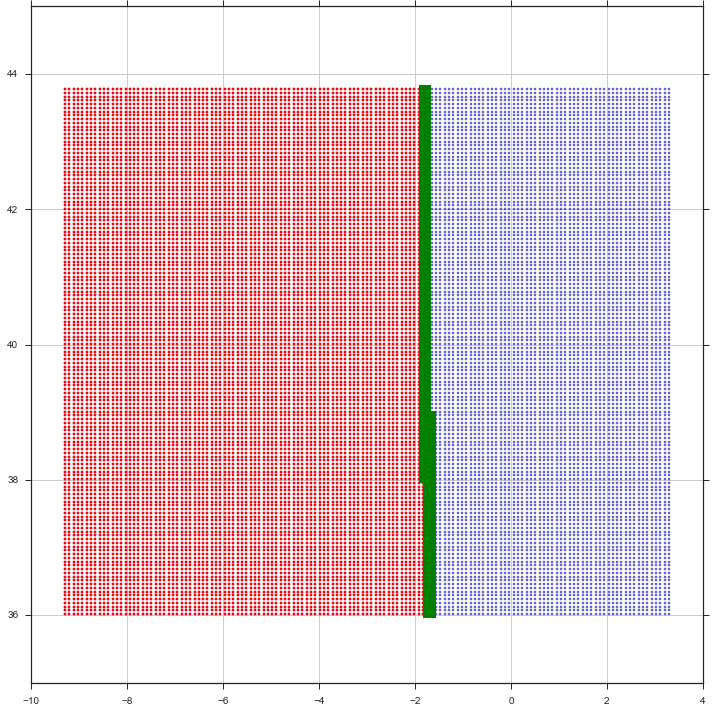

In [41]:
#n = 2500 + 2495
n = n #+ 300
nf = n + 300
plt.figure(figsize=(10,10))
plt.scatter(xs, ys, marker='.', alpha=0.6)
plt.scatter(xs[:n], ys[:n], marker='.', color='red')
plt.scatter(xs[n:nf], ys[n:nf], marker='s', color='g', s=50, linewidth=0, alpha=1)
plt.gca().grid(True)
plt.tight_layout()

# MONTECARLO

## INFORMACIÓN

In [49]:
g = geocoder.google([41.6894079, -0.8427317], method='reverse')

In [50]:
g.json

{'accuracy': 'ROOFTOP',
 'address': 'Diseminado S Gregorio el Cascajo, 9124, 50059 Zaragoza, Zaragoza, Spain',
 'bbox': {'northeast': [41.6924489802915, -0.842331019708498],
  'southwest': [41.6897510197085, -0.8450289802915021]},
 'city': 'Zaragoza',
 'confidence': 9,
 'country': 'ES',
 'county': 'Z',
 'encoding': 'utf-8',
 'housenumber': '9124',
 'lat': 41.6911,
 'lng': -0.84368,
 'location': '41.6894079, -0.8427317',
 'ok': True,
 'postal': '50059',
 'provider': 'google',
 'quality': 'street_address',
 'state': 'Aragón',
 'status': 'OK',
 'status_code': 200,
 'street': 'Diseminado S Gregorio el Cascajo'}

In [120]:
g.json['county']

'Z'

# MUESTREO

In [174]:
calls_remain = 2500

In [68]:
!open report.txt

In [167]:
# googlemaps
# from collections import defaultdict
# montecarlo = defaultdict(lambda : defaultdict(lambda : defaultdict(tuple)))

n = 14264

# MUESTREAR

In [170]:
montecarlo = dict()
ini = n
fin = nf#n + 200


In [175]:
ini, fin

(14264, 14564)

In [176]:
fecha = datetime.now()

In [177]:
report = open('report.txt', 'a')

print('###################### REPORT %s ######################' % fecha, file=report)

for i, yxs in enumerate(zip(ys[ini:fin], 
                          xs[ini:fin])):

    g = geocoder.google(yxs, method='reverse')
    calls_remain -= 1
    print('.', end='')

    try:
        loc = '%s: %s: %s' % (g.json['country'], g.json['state'], g.json['county'])
        print(ini+i, end='\t')
    except:
        print('n:', ini + i,'xys:', yxs, file=report)
        sleep(.8)
        continue

    yx = [list(yxs)]
    montecarlo[loc] = montecarlo.get(loc, yx) + yx
    if calls_remain == 0: break
report.close()
print(calls_remain)

SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


# MAPA DEL MUESTREO

In [159]:
montecarlo

{'ES: Aragón: Huesca': [[41.614341857142854, -0.30424000000000007],
  [41.614341857142854, -0.30424000000000007],
  [41.66979514285714, -0.30424000000000007],
  [41.725248428571426, -0.30424000000000007],
  [41.780701714285712, -0.30424000000000007],
  [41.836154999999998, -0.30424000000000007],
  [41.891608285714284, -0.30424000000000007],
  [41.94706157142857, -0.30424000000000007],
  [42.002514857142856, -0.30424000000000007],
  [42.057968142857142, -0.30424000000000007],
  [42.113421428571428, -0.30424000000000007],
  [42.168874714285714, -0.30424000000000007],
  [42.224328, -0.30424000000000007],
  [42.279781285714286, -0.30424000000000007],
  [42.335234571428572, -0.30424000000000007],
  [42.390687857142858, -0.30424000000000007],
  [42.446141142857144, -0.30424000000000007],
  [42.50159442857143, -0.30424000000000007],
  [42.557047714285716, -0.30424000000000007],
  [42.612501000000002, -0.30424000000000007],
  [42.723407571428574, -0.30424000000000007],
  [42.77886085714286, -0

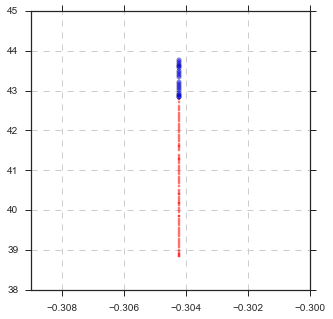

In [160]:
plt.figure(figsize=(5,5))

for k, cs in montecarlo.items():
    x = [c[0] for c in cs]
    y = [c[1] for c in cs]

    if k.startswith('ES'):
        plt.scatter(y, x, color='red', marker='.', alpha=0.5)
    else:
        plt.scatter(y, x, alpha=0.5)

plt.gca().grid(True, linestyle='--')

# ALTERNATIVA

In [161]:
mapquest_api = open('/Users/mmngreco/Documents/mq_api.txt').read()
gmaps_api = open('/Users/mmngreco/Documents/googlemaps_api.txt').read()
geocoder_api = open('/Users/mmngreco/Documents/geocoder_api.txt').read()
mbox_api = open('/Users/mmngreco/Documents/mbox_api.txt').read()

# EXPORTAR DATOS

In [162]:
fname = 'xys.csv'
f = open(fname, 'a')
for key, xys in montecarlo.items():
    for xy in xys:
        print('%s,%s,%s,%s,%s' % (*key.split(': '), *xy), file=f)

f.close()

# COMPROBAMOS LOS DATOS

In [163]:
d = pd.read_csv('xys.csv', header=None)
d.drop_duplicates(inplace=True)

In [164]:
d.columns = ['pais', 'ca', 'prov', 'lat', 'lng']

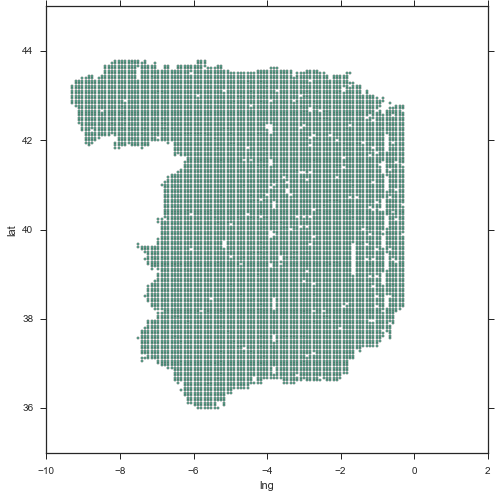

In [165]:
d[d.pais == 'ES'].plot(kind='scatter', x='lng', y='lat', marker='.', figsize=(7,7))
plt.tight_layout()

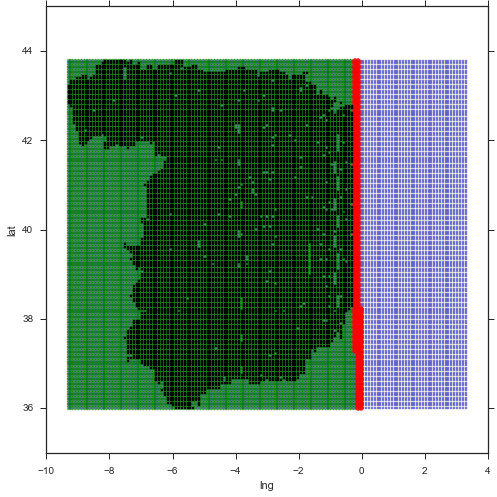

In [168]:
incremento = 300
n = n #+ incremento
nf = n + incremento

plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)

ax.scatter(xs, ys, marker='.', alpha=0.5)
ax.scatter(xs[:n], ys[:n], marker='s', color='g', alpha=0.4)
ax.scatter(xs[n:nf], ys[n:nf], marker='o', color='r', s=20, linewidth=1, alpha=0.8)
d[d.pais == 'ES'].plot(kind='scatter', x='lng', y='lat', marker='.', figsize=(7,7), ax=ax, color='black')

plt.tight_layout()

[MUESTREAR](#MUESTREAR)

AttributeError: 'list' object has no attribute 'dropna'

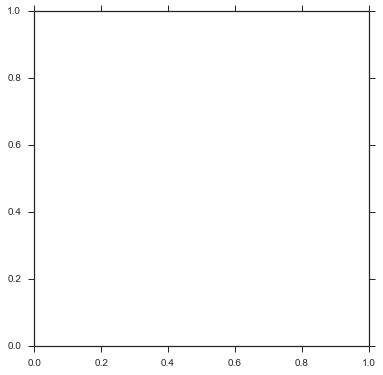

In [94]:
plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1)

xys.dropna(inplace=True)
xys.drop_duplicates(inplace=True)

xys[xys.pais == 'ES'].plot(kind='scatter', x='lng', y='lat', alpha=0.7, ax=ax)

color = sns.color_palette("Set1", 17)
color = sns.color_palette("husl", len(xys[xys.pais == 'ES'].prov.unique()))
#color = sns.color_palette("cubehelix", 17)


#n_color = list(map(int,'9  7 15 14 12 16 10  1  6  8 11 13  0  2  3  4  5'.split()))

for i, region in enumerate(xys[xys.pais == 'ES'].prov.unique()):
#    i = n_color[i]
    xys[xys.prov == region].plot(kind='scatter', 
                                 x='lng', 
                                 y='lat', 
                                 alpha=0.1, 
                                 ax=ax, 
                                 color=color[i], 
                                 marker='o')

plt.xlim(-10,4)
ax.grid(True, linestyle='--')
plt.tight_layout()

In [89]:
ca_iso

,codigo,nombre
0,ES-AN,Andalucía
1,ES-AR,Aragón
2,ES-AS,"Asturias, Principado de"
3,ES-CN,Canarias
4,ES-CB,Cantabria
5,ES-CM,Castilla La Mancha ! Castilla-La Mancha
6,ES-CL,Castilla y León
7,ES-CT,Catalunya (ca) [Cataluña]
8,ES-EX,Extremadura
9,ES-GA,Galicia (gl) [Galicia]


In [82]:
prov_iso

,codigo,nombre,ca
0,ES-C,A Coruña (gl) [La Coruña],GA
1,ES-VI,Alava !Álava Araba (eu),PV
2,ES-AB,Albacete,CM
3,ES-A,Alicante Alacant (ca),VC
4,ES-AL,Almería,AN
5,ES-O,Asturias,AS
6,ES-AV,Avila !Ávila,CL
7,ES-BA,Badajoz,EX
8,ES-PM,Balears (ca) [Baleares],IB
9,ES-B,Barcelona [Barcelona],CT


https://es.wikipedia.org/wiki/F%C3%B3rmula_del_Haversine